In [133]:
import time
import torch as tr
from torch import nn
import torch.optim as opt
from torch.utils.data import DataLoader, Dataset
from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as plt
import numpy as np
import typing
from typing import Callable, Tuple
import matplotlib as mt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from copy import deepcopy

In [134]:
# define device to use (cpu/gpu)
if tr.cuda.is_available():
  print('# of GPUs available: ', tr.cuda.device_count())
  print('First GPU type: ',tr.cuda.get_device_name(0))
device = ('cuda' if tr.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")
     


# of GPUs available:  1
First GPU type:  NVIDIA GeForce RTX 3080
Computation device: cuda



# Deep learning for universal linear embeddings of nonlinear dynamics “Koopman operator”

In this work we try to replicate (and possibly improve) the results of the work done in this [PAPER](https://www.nature.com/articles/s41467-018-07210-0), in which they focus on developing DNN representations of Koopman eigenfunctions that remain interpretable and parsimonious, even for high-dimensional and strongly nonlinear systems.


**Koopman operator:** <p>
The Koopman operator is a linear operator that describes the evolution of scalar observables (i.e., measurement functions of the states) in an infinitedimensional Hilbert space. This operator theoretic point of view lifts the dynamics of a finite-dimensional nonlinear system to an infinite-dimensional function space where the evolution of the original system becomes linear, indeed, the eigenfunctions of the Koopman operator provide intrinsic coordinates that globally linearize the dynamics.


**Dataset:** <p>
All data can be reconstructed using the code available at [GIT](https://github.com/BethanyL/DeepKoopman).


**Network architecture:** <p>

We implement the original architecture of the above-mentioned paper, which will be discussed in detail below.

## Mathematical formulation of Koopman theory
The object of the discussion are discrete-time dynamical systems:
$$\textbf{x}_{k+1} = \textbf{F}(\textbf{x}_k)$$
where $\textbf{x} \in \mathbb{R}^n $ is the state of the system and $\textbf{F}$ represents the dynamics that map the state of the system forward in time. In the case of linear dynamics, the map $\textbf{F}$ is a matrix that advances the state $\textbf{x}$ and the dynamics of these linear systems admit a universal solution in terms of the eigenvalues and eigenvectors of the matrix $\textbf{F}$. 
In 1931, B.O. Koopman provided an alternative description of dynamical systems in terms of the evolution of functions in the Hilbert space of possible measurements $\textbf{g}(\textbf{x})$ of the state. The so-called *Koopman operator*, $\mathcal{K}$, that advances measurement functions is an infinite-dimensional linear operator such that

$$\mathcal{K}\textbf{g} := \textbf{g}\ \circ \textbf{F}\ \ \ \text{i.e.}\ \ \mathcal{K}\textbf{g}(\textbf{x}_k) = \textbf{g}(\textbf{x}_{k+1})$$

 Representing nonlinear dynamics in a linear framework, via the Koopman operator, has the potential to enable advanced nonlinear prediction using the theory developed for linear systems. However, obtaining finite-dimensional approximations of the infinite-dimensional Koopman operator has proven challenging in practical applications. In many approaches, they try to identify eigenfunctions of the Koopman operator directly, satisfying:

 $$\varphi(\textbf{x}_{k+1}) = \mathcal{K} \varphi(\textbf{x}_k) = \lambda \varphi(\textbf{x}_k).$$

 In practice, Koopman eigenfunctions may be more difficult to obtain than the solution of the discrete dynamics evolution equation we wrote in the begininning, however, these eigenfunctions are guaranteed to span an invariant subspace, and the Koopman operator will yield a matrix when restricted to this subspace, thus arriving at a description of the evolution of the system in terms of a finite dimensional linear operator.

## Data Handling
The authors of the study we are following found Koopman eigenfunctions in several example systems, including a simple model with a discrete spectrum and two examples that exhibit a continuous spectrum: the nonlinear pendulum and the high-dimensional unsteady fluid flow past a cylinder. They created the datasets by solving the systems of differential equations in MATLAB using the ode45 solver.

For each dynamical system, they choose 5000 initial conditions for the test set, 5000 for the validation set, and 5000 - 20000 for the training set. For each initial condition, the differential equations were solved for some time span.

We decided to not generate new data, but to import the ones they already used in order to compare the results. These datasets can be found in the above-mentioned github.

In [135]:
# Max number of initial conditions to be considered in order to build the train, validation and test datasets. If it is set to 'None', all possible initial conditions are taken.
max_initial_conditions=None

In [136]:
option                           =3
exp=[                            # Options: 
     "DiscreteSpectrumExample",  # 1)
     "FluidFlowBox",             # 2)
     "FluidFlowOnAttractor",     # 3)
     "Pendulum"                  # 4)
     ]

# Network architecture

In this work they tried to identify only a *few key* intrinsic coordinates $\textbf{y} = \varphi(\textbf{x})$ spanned by a set of Koopman eigenfunctions $\varphi: \mathbb{R}^p \rightarrow \mathbb{R}^n$, in the context of a dynamical system $\textbf{y}_{k+1}=\textbf{Ky}_k$. In particular, intrinsic coordinates which are useful in order to recostruct the dynamics are those for which $\textbf{y} = \varphi(\textbf{x})$, hence, the state x can be recovered with the inverse $\textbf{x} = \varphi^{-1}(\textbf{y})$ so that the state x may be recovered. This is achieved using an auto-encoder (in the following picture), where the action of $\varphi$ is implemented by the encoder and the action of $\varphi^{-1}$ by the decoder. The dimension p of the auto-encoder subspace is a hyperparameter of the network that the authors of the paper have chosen guided by knowledge of the system and subsequently tuned. So we decided to follow their choices.

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41467-018-07210-0/MediaObjects/41467_2018_7210_Fig1_HTML.png?as=webp" style="width: 40%; margin-left: 30%; margin-right: 30%;"/>

The network have some hidden layer in the encoder and in the decoder whose number and width depends on the specific system. They are followed by an activation with the ReLU. The output layers of the encoder and the decoder are linear.

Moreover, they generalized this framework to include a broad class of nonlinear systems that exhibit a continuous eigenvalue spectrum $\lambda$. A continuous spectrum is characterized by a continuous range of observed frequencies, as opposed to the discrete spectrum consisting of isolated, fixed frequencies. This phenomena is observed in a wide range of physical systems that exhibit broadband frequency content, such as turbulence and nonlinear optics. The continuous spectrum spoils the simple Koopman descriptions, as there is not a straightforward finite approximation in terms of a small number of eigenfunctions. Indeed, away from the linear regime, an infinite Fourier sum is required to approximate the shift in frequency and eigenfunctions due to the non linearity.
To deal with this problem, they allowed the eigenvalues of the matrix $\textbf{K}$ to vary, parametrized by the function $\lambda = \Lambda(\textbf{y})$, which is learned by an auxiliary network (in the following figure). The eigenvalues $\lambda_{\pm} = \mu \pm i \omega$ are then used to parametrize block-diagonal $\textbf{K}(\mu,\omega)$.
In particular, they built separate auxiliary networks, one for the complex conjugate pair of eigenvalues and one for the the real eigenvalue. In this way, we can avoid to perform an infinite asymptotic expansion of the eigenfunctions. So, the resulting networks remain parsimonious, and the few key eigenfunctions are interpretable.

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41467-018-07210-0/MediaObjects/41467_2018_7210_Fig2_HTML.png?as=webp" style="width: 40%; margin-left: 30%; margin-right: 30%;"/>



Also in this case, we have hidden layers whose number and dimension vary according to the specific system and the output layer is linear.

In [137]:
if option not in range(1,5):
    raise Exception("Option invalid, please stick with the option proposed...")
dataDir="data/"
match exp[option-1]:
    case "DiscreteSpectrumExample":
        coor         =2                     # Number of generalized spatial coordinates of the experiment.
        max_tr       =3                     # Number of files provided by the authors for training.
        dimEncoder   =[30,30,2]             # Width of Encoder (the input layer has dimension `coor` and it is implicit, the dimension of the last layer is the dimension of the finite-dimensional representation of Koopman space).
        dimAuxNet    =[10,10,10]            # Width of Auxiliary Network 
                                            #   (first dimension is implicit and it is the dimension of the Koopman subspace, last one is implicit and it is
                                            #   the number of parameters needed to construct the Jordan Matrix)
        RE_IMG_eigAux=(2,0)                 #   number of real eigenvalues of the K Jordan matrix (1x1 blocks) and of complex eigenvalues (2x2 blocks).
        impRadialSymm=True                  # If setted to `True` give to the Auxiliary net radial distance from the origin of the encoded point (if setted to `False` give the coordinates)
        numShift     =30                    # Lenght of the trajectories considered for the prediction part of the loss
        numLinShift  =50                    # Lenght of the trajectories condidered for the linear-evolution part of the loss
        lamb         =[0.1,0.1,1.0,1e-7]    # Relative weights of various loss contributions.
        lamb_l2      =1e-15                 # L2 regularizing loss weight.
        lr           =1e-3                  # Learning rate.
        Dt           =0.02                  # Time scale of the experiment, it represent the difference in time between two temporal steps in the trajectories.
        lenTrj       =51                    # Lenght of integrated trajectory in the provided files.
        batchSize    =256                   # Batch size (all computation on batch elementes are indipendent and parallelizable). 
                                            #   The loss and the metric results are taken as the mean on a batch.
        """
        The Network geometry is: 
                                                                                                                        
              Encoder                                           Decoder   
            +-----------\                                   ------------+
            |         |\ -----\        K matrix         ---/  |         |
            |         | \      ----\               ----/      |         |
            |         |  \          --------------/           |         |
            |         |   \           |         |             |         |
            |         |    \          |         |             |         |
            |         |     \         |         |             |         |
            |         |      |        |         |             |         |
            |         |      \     -----------------          |         |
            |         |    -------/   |        /    \------   |         |
            +-------------/    \     /        /            \------------+
                       -\       \    |       /                           
                         \       \   |      /                            
                         \       \  |     /                             
                          -\      \/    -/                              
                            -------|   /                                
                            |      |  /                                 
                            |      | /                                  
                            |      |/                                   
                            +------/                                    
                         Auxiliary net        
        
        The Encoder is constituted by `len(dimEncoder)` linear layers. All the layers except for the last one are followed by a
        ReLU activation layer, which injects non-linearity in the Encoder. The decoder has the same structure but in reverse order:
        the first layer has not a ReLU applied to it (as it is the input layer), and provides the dimension of the subspace in which
        the Koopman operator is finitely-represented, while the output is in the phase space (has the same dimension as the input of the Encoder).
        The K-matrix is a block-diagonal Jordan matrix in which the real eigenvalues are associated to 1x1 blocks, parametrized by μ [exp(μ*Δt)];
        the complex eigenvalues are associated to 2x2 blocks, parametrized by μ, ω:    exp(μ*Δt)*[[ cos(ω*Δt),-sin(ω*Δt)],
                                                                                                  [ sin(ω*Δt), cos(ω*Δt)]]
        In order to determine the values of μ and ω, there exists an Auxiliary Network constitued by `len(dimAuxNet)` linear layers
        followed by a ReLU (except for the last one).
        """
        seqEncoder=(
                    nn.Linear(coor          ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,dimEncoder[1]),nn.ReLU(),
                    nn.Linear(dimEncoder[1] ,dimEncoder[2])
                    )
        seqDecoder=(
                    nn.Linear(dimEncoder[2] ,dimEncoder[1]),nn.ReLU(),
                    nn.Linear(dimEncoder[1] ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,coor         )
                    )
        tmpAuxInputDim=dimEncoder[-1] if not impRadialSymm else 1
        auxNet    =(
                    nn.Linear(tmpAuxInputDim,dimAuxNet[0]),nn.ReLU(),
                    nn.Linear(dimAuxNet[0]  ,dimAuxNet[1]),nn.ReLU(),
                    nn.Linear(dimAuxNet[1]  ,dimAuxNet[2]),nn.ReLU(),
                    nn.Linear(dimAuxNet[2]  ,1           )
                    )
    case "FluidFlowBox":
        coor         =3
        max_tr       =4
        dimEncoder   =[130,3]
        dimAuxNet    =[20,20]
        RE_IMG_eigAux=(1,1)
        impRadialSymm=False
        numShift     =30
        numLinShift  =100
        lamb         =[0.1,0.1,1.0,1e-9]
        lamb_l2      =1e-13
        lr           =1e-3
        Dt           =0.01
        lenTrj       =101
        batchSize    =128
        seqEncoder=(
                    nn.Linear(coor          ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,dimEncoder[1])
                    )
        seqDecoder=(
                    nn.Linear(dimEncoder[1] ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,coor         )
                    )
        tmpAuxInputDim=dimEncoder[-1] if not impRadialSymm else 1
        auxNet    =(
                    nn.Linear(tmpAuxInputDim,dimAuxNet[0]),nn.ReLU(),
                    nn.Linear(dimAuxNet[0]  ,dimAuxNet[1]),nn.ReLU(),
                    nn.Linear(dimAuxNet[1]  ,1           )
                    )

    case "FluidFlowOnAttractor":
        max_tr       =3
        coor         =3
        dimEncoder   =[105,2]
        dimAuxNet    =[300]
        RE_IMG_eigAux=(0,1)
        impRadialSymm=True
        numShift     =30
        numLinShift  =120 
        lamb         =[0.1,0.1,1.0,1e-7]
        lamb_l2      =1e-13
        lr           =1e-3
        Dt           =0.05
        lenTrj       =121
        batchSize    =256
        seqEncoder=(
                    nn.Linear(coor          ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,dimEncoder[1])
                    )
        seqDecoder=(
                    nn.Linear(dimEncoder[1] ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,coor         )
                    )
        tmpAuxInputDim=dimEncoder[-1] if not impRadialSymm else 1
        auxNet    =(
                    nn.Linear(tmpAuxInputDim,dimAuxNet[0]),nn.ReLU(),
                    nn.Linear(dimAuxNet[0]  ,1           )
                    )

    case "Pendulum":
        max_tr       =6
        coor         =2
        dimEncoder   =[80,80,2]
        dimAuxNet    =[170]
        RE_IMG_eigAux=(0,1)
        impRadialSymm=True
        numShift     =30
        numLinShift  =50 
        lamb         =[0.001,0.001,1.0,1e-9]
        lamb_l2      =1e-14
        lr           =1e-3
        Dt           =0.02
        lenTrj       =51
        batchSize    =128
        seqEncoder=(
                    nn.Linear(coor          ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,dimEncoder[1]),nn.ReLU(),
                    nn.Linear(dimEncoder[1] ,dimEncoder[2])
                    )
        
        seqDecoder=(
                    nn.Linear(dimEncoder[2] ,dimEncoder[1]),nn.ReLU(),
                    nn.Linear(dimEncoder[1] ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,coor         )
                    )
        tmpAuxInputDim=dimEncoder[-1] if not impRadialSymm else 1
        auxNet    =(
                    nn.Linear(tmpAuxInputDim,dimAuxNet[0]),nn.ReLU(),
                    nn.Linear(dimAuxNet[0]  ,1           )
                    )
    case EXP:
        raise Exception(f"Experiment Option not found.... [{EXP}]")




        
filesTrain=[dataDir+exp[option-1]+"_train"+str(i)+"_x.csv" for i in range(1,max_tr+1)]
fileVali=dataDir+exp[option-1]+"_val_x.csv"
fileTest=dataDir+exp[option-1]+"_test_x.csv"
print("Experiment",exp[option-1]+", files train:")
for f in filesTrain:
    print("\t\t"+f)
print("\nFile Validation:\t",fileVali)
print("File Test:\t\t",fileTest)

Experiment FluidFlowOnAttractor, files train:
		data/FluidFlowOnAttractor_train1_x.csv
		data/FluidFlowOnAttractor_train2_x.csv
		data/FluidFlowOnAttractor_train3_x.csv

File Validation:	 data/FluidFlowOnAttractor_val_x.csv
File Test:		 data/FluidFlowOnAttractor_test_x.csv


In [138]:
class customDataSet(Dataset):
    '''
    Dataset used to train, validate and test the model, 
        It is a dataset array (can be subscripted) and its i-th element is a trajectory constitued by `Nshift` elements 
    '''
    def __init__(self, filenames: str|list[str], coor: int, Nshift: int, NLshift: int, lenTraje: int, debug: bool = False) -> None:
        '''
        `filenames` indicates a filename or a list of filenames where the data are stored. If provided a list of names it will concatenate their contents.
        `coor`      indicates the number of coordinates in the phase space trajectories.
        `Nshift`     indicates the lenght of the trajectories to be considered (it must be <= than `lenTraje`) for the prediction part of the loss
        `NLshift`    indicates the lenght of the trajectories to be considered (it must be <= than `lenTraje`) for the linear-evolution part of the loss
        `lenTraje`  it is the lenght of the trajectories in the csv file (generated by integration algorithms)
        `debug`     if set to 'True', it adds a private attribute to the class named _dataPD, and it is a pandas DataFrame containing all the data read.
        '''
        super().__init__()
        self._data=tr.Tensor([])
        self._Nshift =Nshift
        self._NLshift=NLshift
        self._maxNshift=max(Nshift,NLshift)
        self._coor=coor
        self._event4file=[]
        names=["x_"+str(i) for i in range(coor)]
        multiplefiles=False
        if isinstance(filenames,list):
            L=len(filenames)
            if L>1:
                multiplefiles=True
            else:
                filenames=filenames[0]
        if multiplefiles:
            self._dataPD=pd.concat([pd.read_csv(f,header=None,names=names) for f in filenames])
        else:
            self._dataPD=pd.read_csv(filenames,names=names) 
        
        if (lenTraje<=self._maxNshift):
            raise Exception(f"Trajectories in file is lenTraje={lenTraje} long, but you want to extract {self._maxNshift} time steps")
        IC=len(self._dataPD)//lenTraje
        for i in range(IC if max_initial_conditions==None or IC<max_initial_conditions else max_initial_conditions):
            tmp=[tr.tensor(self._dataPD[i*lenTraje+j:i*lenTraje+j+self._maxNshift+1].values).unsqueeze(0).float() for j in range(lenTraje-self._maxNshift)]
            self._data=tr.cat((self._data,*tmp)) # This will put as first dimension the  numebr of time-shift, the second-one is the batch size and third the number of coordinates

        if not debug:
            self._dataPD=None

    
    def __len__(self) -> int:
        '''
        return the number of initial conditions aka the number of examined trajectories(the length of them are the maximub between `Nshift` and `NLshift`) 
        '''
        return len(self._data)

    def __getitem__(self,i: int) -> tr.tensor:
        '''
        return the trajectory with i-th initial conditions
        N.B. if `lenTraje` > max(`Nshift`,`NLshift`) and i-th initial condition is multiple of `lenTraje` (a true different trajectory)
             the (i+1)-th initial condition will be i-th trajectory shifted in future by one time-step
        '''
        return self._data[i]

In [139]:
# We create the datasets for training, validate and test the model using the files listed above  ^ ^ ^
DATA_TR=customDataSet(filesTrain,coor,numShift,numLinShift,lenTrj)
DATA_VL=customDataSet(fileVali  ,coor,numShift,numLinShift,lenTrj)
DATA_TS=customDataSet(fileTest  ,coor,numShift,numLinShift,lenTrj)

In [140]:
# From the datasets we create DataLoaders that group our datasets in batches
train=DataLoader(DATA_TR,batch_size=batchSize,shuffle=True ,drop_last=True)
vali =DataLoader(DATA_TR,batch_size=batchSize,shuffle=True ,drop_last=True)
test =DataLoader(DATA_TR,batch_size=batchSize,shuffle=False,drop_last=True)

## Loss function
The loss function they decided to use (and obviously the architecture itself) enforces constraints specifically designed to extract the fewest meaningful eigenfunctions; it consists of three weighted mean-squared error components: a reconstruction loss $\mathcal{L}_{recon}$, included in order to obtain a good reconstruction accuracy of the auto-encoder, the loss future state prediction $\mathcal{L}_{pred}$, necessary to have intrinsic coordinates that allow future state prediction,  linearity of dynamics loss $\mathcal{L}_{lin}$, which enforces linear prediction over m time steps. They also use a $\mathcal{L}_{\infty}$
 term to penalty the data point with the largest loss. They also add $ℓ_2$
 regularization on the weights W to reduce overfitting. We decided to not do that because and we simply thought to make the weights smaller by adding a weight decay to Adam. However, as pointed out in [this paper](https://openreview.net/pdf?id=rk6qdGgCZ), the two things do not coincide, but we still found it effective in reducing overfitting. Their loss is:
 $$ \mathcal{L} = \alpha_1 (\mathcal{L}_{recon} + \mathcal{L}_{pred}) + \mathcal{L}_{lin} + \alpha_2 \mathcal{L}_{\infty} + \alpha_3 ||\textbf{W}||^2_2$$
 
 $$ \mathcal{L}_{recon} = ||\textbf{x}_1 - \varphi^{-1}(\varphi(\textbf{x}_1))||_{\text{MSE}}$$
 $$ \mathcal{L}_{pred} = \frac{1}{S_p} \sum_{m=1}^{S_p} ||\textbf{x}_{m+1} -  \varphi^{-1}(K^m \varphi(\textbf{x}_1))||_{\text{MSE}}$$
 $$ \mathcal{L}_{lin} = \frac{1}{T - 1} \sum_{m=1}^{T-1} ||\varphi(\textbf{x}_{m+1}) - K^m \varphi(\textbf{x}_1)||_{\text{MSE}}$$
  $$ \mathcal{L}_{\infty} = ||\textbf{x}_1 - \varphi^{-1}(\varphi(\textbf{x}_1))||_{\infty} + ||\textbf{x}_2 - \varphi^{-1}(K\varphi(\textbf{x}_1))||_{\infty}$$
  where $\text{MSE}$ refers to mean squared error and T is the number of time steps in each trajectory. The weights $\alpha_1$, $\alpha_2$, and $\alpha_3$ are hyperparameters which are different for each example. The integer $S_p$ is a hyperparameter for how many steps to check in the prediction loss. In our case we do not have the term proportional to $|| W ||_2^2|| $ and the weight decay was set equal to $\alpha_3$.


In [141]:
class CustomLoss(nn.Module):
    '''
    The loss proposed in the paper was made up of 5 differents conponents.
    - The first one is a "reconstruction" loss. It is computed using MSELoss between the first time-step of a trajectory and the same encoded and then decoded without
        using the K-matrix to evolve temporally the point. It checks the goodness of the reconstruction of the input data. (it will impose that the autoencoder part 
        approximates the identity transformation so the encoding transformation could be interpreted as a geometric non-linear change of basis).
    - The second one is responsible for the predictive power of the Network, it will compare the point shifted in time (without using the Koopman matrix) with the 
        with the correspondent one, encoded and evolved applying different times the Koopman matrix and then decoded.
        `Nshift`     indicates the lenght of the trajectories to be considered for this part of the loss
    - The third one has to impose the linearity of the tranformation that evolves in time the system (trying to decouple the geometric transformation and the time evolution).
        it is calculated computing the MSELoss between the true encoded version of a point of a trajectory in the Koopman subspace, and the correspondent one evolved from 
        the first point (it is similar to the second one but in Koopman subspace). 
        `NLshift`    indicates the lenght of the trajectories to be considered for this part of the loss
    - The fourth is the L∞ norm between a point and its encoded-decoded version, and between a point shifted one step in the future and its prediction.
    The last contribution is the L2 regularisation of the weights. It is needed to avoid overfitting and to enforce that the value of weights is near 0, to exploit at its best
    the non-linearity of the activation functions. We choose to implement this regularisation loss using a `weight_decay` in the Adam Optimizer, as standard procedure to 
    regularize weights in pytorch. This method it's almost identical to a L2 regularisation (the contribution in the loss is proportional to the magnitude of the weights), 
    but we found out there are some differences highlighted in a paper found at link https://openreview.net/pdf?id=rk6qdGgCZ
    '''
    def __init__(self, Nshift: int, NLshift: int, lamb: Tuple[float, float, float, float]) -> None:
        super().__init__()
        self._Nshift =Nshift
        self._NLshift=NLshift
        self._lamb   =lamb
        self.loss_reco=nn.MSELoss()
        self.loss_pred=nn.MSELoss()
        self.loss_line=nn.MSELoss()
        self.loss_linf: Callable[[tr.tensor,tr.tensor,tr.tensor,tr.tensor],tr.tensor]=\
            lambda x,y,x1,y1: ((x-y).abs().max(dim=-1)[0]+(x1-y1).abs().max(dim=-1)[0]).mean()

    #XT contains the true time-evolved starting from the initials points of trajectories in a batch, YT the predicted ones.
    def forward(self, XT: tr.tensor, YT: tr.tensor, phiT: tr.tensor, phiPredT: tr.tensor) -> tr.tensor:
        if len(XT)<=max(self._NLshift,self._Nshift):
            raise Exception(f"The data provided to calculate loss haven't enough elements to fulfill the requirement of\
                              {self._Nshift} time steps for the prediciton loss and {self._NLshift} for the linear part [len(X)={len(XT)}]")

        totLoss=        self.loss_reco(XT[0],YT[0]) * self._lamb[0]    # better not to use implace operation += to preserve possibility to backpropagate
                                                                       # the gradient using the computational graph created by pythorch
        totLoss=totLoss+self.loss_pred(XT[1:self._Nshift+1],YT[1:self._Nshift+1])           * self._lamb[1]
        totLoss=totLoss+self.loss_line(phiT[1:self._NLshift+1],phiPredT[1:self._NLshift+1]) * self._lamb[2]
        totLoss=totLoss+self.loss_linf(XT[0],YT[0],XT[1],YT[1])                             * self._lamb[3]

        return  totLoss

      

In [142]:
metric   = MeanAbsoluteError() # As metric we used the MAE between a point evolved one time step in the future and the correspondent prediction done by the Net
loss     = CustomLoss(numShift,numLinShift,lamb)

In [143]:
class Encoder(nn.Module):
    '''
    This the implementation of the Encoder
    '''
    def __init__(self,layers: Tuple[nn.Module, ...]) -> None:
        super().__init__()
        self.layers=nn.Sequential(*layers)
    def forward(self,x: tr.tensor) -> tr.tensor:
        return self.layers(x)

class Decoder(nn.Module):
    '''
    This the implementation of the Decoder
    '''
    def __init__(self, layers: Tuple[nn.Module, ...]) -> None:
        super().__init__()
        self.layers=nn.Sequential(*layers)
    def forward(self, x: tr.tensor) -> tr.tensor:
        return self.layers(x)


#==================================================================================================
#--------------------------------------------------------------------------------------------------
#==================================================================================================

class REAL_AuxNet(nn.Module):
    '''
    The Auxiliary Net provides the parametrization for one real value, but we need different parameters according
    to the block that we want to construct. `REAL_AuxNet` provides one parameters: μ
    '''
    def __init__(self, layers: Tuple[nn.Module, ...]) -> None:
        super().__init__()
        self.layers=nn.Sequential(*layers)
    def forward(self, x: tr.tensor) -> tr.tensor:
        return self.layers(x)
        
class COMPLEX_AuxNet(nn.Module):
    '''
    The Auxiliary Net provide the parametrization of one real value, but we need different parameters according
    to the block that we want to construct. `COMPLEX_AuxNet` provides, using two `REAL_AuxNet`, the parameters μ, ω
    '''
    def __init__(self, layers: Tuple[nn.Module, ...]) -> None:
        super().__init__()
        # Real part parameter μ AuxNet
        self.AuxR=REAL_AuxNet(layers)
        # Immaginary part parameter ω AuxNet
        self.AuxI=REAL_AuxNet(deepcopy(layers)) # We used a `deepcopy` of the layers because we want them 
                                                #    with indipendent parameters (different location in memory)
    def forward(self,x: tr.tensor) -> tr.tensor:
        return self.AuxR(x), self.AuxI(x)

#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------

class _RealEntry(nn.Module):
    '''
    `_RealEntry` takes as input `Dt` (difference in time between two adiacent steps) and the tensor from which we extract the information to determine
    the value of the continuous parameters. It outputs a 1x1 block.
    '''
    def __init__(self, layers: Tuple[nn.Module, ...], RealComplex_EigenValues: Tuple[int, int], Dt: float) -> None:
        '''
        `layers` is a tuple containing the layers for the Auxiliary Network.
        `RealComplex_EigenValues` is a tuple with the number of 1x1 blocks related with real eigenvalues, and the number of 2x2 blocks
                                  related to the complex eigenvalues of the Jordan matrix rappresenting the evolution in time.
        '''
        super().__init__()
        # Number of Real 1x1 blocks
        self._NReal=RealComplex_EigenValues[0]
        # Total width of Jordan matrix (n rows and n columns)
        self.n=self._NReal+RealComplex_EigenValues[1]*2
        self.Dt=Dt

        # Modules to generate all the parameters we need to create the real blocks
        for i in range(self._NReal):
            tmp=deepcopy(layers) # We used a `deepcopy` of the layers because we want them with indipendent parameters (different location in memory)
            self.add_module(str(i),REAL_AuxNet(tmp))

    def forward(self,indexBlock: int,x: tr.tensor) -> tr.tensor:
        u=self[indexBlock](x)
        # -------------- Block
        R=tr.exp(u*self.Dt)
        # --------------------
        return R
    def __getitem__(self,index: int) -> nn.Module:
        return getattr(self,str(index))


class _JordanBlock(nn.Module):
    '''
    `_JordanBlock` takes as input `Dt` (difference in time between two adiacent steps) and the tensor from which extract the information to determine
    the value of the continuous parameters. It outputs a block 2x2 as an array of dimension 4+(`n`-2) with 2 entries with true parameters,
    (`n`-2) zeros padded and other 2 entries. This procedure is done in this way because for technical reasons we preferred to compose the Jordan matrix 
    starting from an array with lenght n*n made of the blocks concatenated, reshaped to a "n x n" tensor.
    '''
    def __init__(self, layers: Tuple[nn.Module, ...], RealComplex_EigenValues: Tuple[int, int], Dt: float, BatchSize: int =1) -> None:
        '''
        `layers` is a tuple containing the layers for the Auxiliary Network.
        `RealComplex_EigenValues` is a tuple with the number of 1x1 blocks related with real eigenvalues, and the number of 2x2 blocks
                                  related to the complex eigenvalues of the Jordan matrix rappresenting the evolution in time.
        '''
        super().__init__()
        # Number of Complex 2x2 blocks
        self._NComplex=RealComplex_EigenValues[1]
        # Total width of Jordan matrix (n rows and n of columns)
        self.n=RealComplex_EigenValues[0]+self._NComplex*2
        self.Dt=Dt
        self._batchSize=BatchSize

        # Modules to generate all the needed parameters for complex blocks
        for i in range(self._NComplex):
            tmp=deepcopy(layers) # We used a `deepcopy` of the layers because we want them with indipendent parameters (different location in memory)
            self.add_module(str(i),COMPLEX_AuxNet(tmp))
        # Register buffer to move it with model from CPU to GPU
        self.register_buffer('_PAD', tr.zeros((self._batchSize,self.n-2),requires_grad=True))

    def forward(self,indexBlock: int,x: tr.tensor) -> tr.tensor:
        u,w=self[indexBlock](x)
        R=tr.exp(u*self.Dt)
        padd=PAD=getattr(self, '_PAD')
        # -------------- Block
        Block=tr.cat([R*tr.cos(w*self.Dt),-R*tr.sin(w*self.Dt),padd,R*tr.sin(w*self.Dt),R*tr.cos(w*self.Dt)],dim=-1) 
        # --------------------
        return Block
    def __getitem__(self,index: int) -> nn.Module:
        return getattr(self,str(index))

#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------

class customMatrix(nn.Module):
    '''
    This Net will merge the various Jordan Blocks and compose the torch tensor representing the matrix. The blocks are composed choosing the real
    parameters starting from the point in the Koopman subspace of my system (the output of the decoder).
    `Dt` is the difference in time between two adiacent steps.
    '''
    def __init__(self, layers: Tuple[nn.Module, ...], RealComplex_EigenValues: Tuple[int, int], Dt: float, BatchSize: int =1) -> None:
        '''
        `layers` is a tuple containing the layers for the Auxiliary Network.
        `RealComplex_EigenValues` is a tuple with the number of 1x1 blocks related with real eigenvalues, and the number of 2x2 blocks
                                  related to the complex eigenvalues of the Jordan matrix rappresenting the evolution in time.
        '''
        super().__init__()
        # We store the number of real and complex blocks
        self._NReal,self._NComplex=RealComplex_EigenValues
        # We compute the width of the matrix
        self.n=self._NReal+self._NComplex*2
        # We store the required Networks to fix the parameters of the matrix
        if self._NComplex>0: self._JB=_JordanBlock(layers,RealComplex_EigenValues,Dt,BatchSize)
        if self._NReal>0:    self._RE=_RealEntry(layers,RealComplex_EigenValues,Dt)

        self._batchSize=BatchSize
        # Register buffer to move it with model from CPU to GPU
        self.register_buffer('_PAD', tr.zeros((self.n,self._batchSize),requires_grad=True))
        
    def forward(self,x: tr.tensor) -> tr.tensor:
        # Here we'll store the tensors, from now it will contain the list of blocks to concatenate
        matrixlist=[]

        for i in range(self.n):
            for j in range(self.n):
                addedBlock=False
                # The matrix is built putting first the complex blocks on the diagonal
                if i==j and i%2==0 and i<self._NComplex*2:                  #        |
                    # COMPLEX BLOCKS                                        #        |
                    B=self._JB(i//2,x).T                                    #        | 
                    matrixlist.append(B)                                    #        |  
                    addedBlock=True                                         #        |  
                                                                            #        /  
                # Then the real blocks  <-------------------------__________________/
                elif i==j and i >=self._NComplex*2:
                    # REAL BLOKS
                    B=self._RE(i-self._NComplex*2,x).T
                    matrixlist.append(B)
                    addedBlock=True

                if addedBlock:
                    # We Padd with zeros between blocks to center them in the diagonal after the reshape
                    PAD=getattr(self, '_PAD')
                    matrixlist.append(PAD)
        # We concatenate the blocks
        matrix=tr.cat(matrixlist[:-1])
        # We shape them as a matrix
        matrix=matrix.reshape((self.n,self.n,self._batchSize))
        # We permute the axes to have the batch dimension as the first one and to perform operations on the batches in parallel
        matrix=matrix.permute((2,0,1)) 
        return matrix

#==================================================================================================
#--------------------------------------------------------------------------------------------------
#==================================================================================================

class K_Matrix(nn.Module):
    '''
    `K_Matrix` is the realization of the whole process of fixing the continous parameters and applying the matrix. It is responsible of the evolution
    in time. It acts on the Koopman subspace.
    If it is initialized with `radialSymmetry` setted to True, the matrix eigenvalues will be calculated from vector lenght information (not direction)
    `Dt` difference in time between two adiacent steps
    '''
    def __init__(self, layersAuxNets: Tuple[nn.Module, ...], RealComplex_EigenValues: Tuple[int, int], Dt: float, radialSymmetry: bool =False, BatchSize: int =1) -> None:
        super().__init__()
        # We store the number of real and complex blocks
        self._NReal,self._NComplex=RealComplex_EigenValues
        # We compute the width of the matrix
        self.n=self._NReal+self._NComplex*2
        self._radialSymmetry=radialSymmetry
        self.matrix=customMatrix(layersAuxNets,RealComplex_EigenValues,Dt,BatchSize)

    def forward(self,x: tr.tensor) -> tr.tensor:
        if self.n != len(x[0]):
            raise Exception(f"Jordan Koopman matrix has dimension {self.n}x{self.n} but input has dimension {len(x[0])}....")
        
        # We compose the Jordan matrix fixing the real parameters:

        # If radial symmetry is set to `True`, the input for the Auxiliary Network is only the magnitude of the vector, not the direction
        xtmp=x if not self._radialSymmetry else x.norm(dim=-1).unsqueeze(-1)
        M=self.matrix(xtmp)
        # We evolve in time applying the matrix product between the point in Koopman subspace and the Jordan matrix
        res=M.bmm(x.unsqueeze(-1)).squeeze(-1) # N.B. the matrix is shaped (`batchSize`,`n`,`n`) with `n` the dimension of the Koopman subspace.
                                               #      to perform batch matrix multplication we had to tranform the vector in a `n`x 1 matrix 
                                               #      (`batchSize`,`n`,1). Than we had to squeeze back the result in vectorial form (`batchSize`,`n`)
        return res



In [144]:
class KOOPMAN(nn.Module):
    '''
    KOOPMAN Net is the whole composition of encoder, K_matrix (the matrix in itself and all the auxiliary networks) and decoder
    If it is initialized with `radialSymmetry` setted to True, the K_matrix eigenvalues will be calculated from vector lenght information (not direction)
    `Dt` difference in time between two adiacent steps
    '''
    def __init__(self
                , layersEncoder: Tuple[nn.Module, ...]
                , layersDecoder: Tuple[nn.Module, ...]
                ,  layersAuxNet: Tuple[nn.Module, ...]
                ,  RealComplex_EigenValues: Tuple[int, int], Dt: float, NShift: int, radialSymmetry: bool =False, BatchSize: int =1) -> None:
        '''
        `Dt` is the time elapsed between two different trajecory points
        `NShift` is the number of time-shifts considered (the lenght of the trajectory).
        '''
        super().__init__()
        self.ENC=Encoder(layersEncoder)
        self.K=K_Matrix(layersAuxNets=layersAuxNet,RealComplex_EigenValues=RealComplex_EigenValues,Dt=Dt,radialSymmetry=radialSymmetry,BatchSize=BatchSize)
        self.DEC=Decoder(layersDecoder)
        self.NShift=NShift
        self._batchSize=BatchSize

    def forward(self, XT: tr.tensor) -> Tuple[tr.tensor,tr.tensor,tr.tensor,tr.tensor]:
        '''
        The input of the Net is a (`numShift+1`,`batchSize`,`coord`) `XT`, the first dimension indicates time position in the trajectory, the second
        one the batch dimension, the third one the geometric dimension of generalized spatial coordinate in the phase space of the experiment.
        '''
        PhiT=self.ENC(XT)   # This will encode all the coodinates at all the times
        arr=[]              # This will contain all the subsequents time steps evolved from the initial condition in Koopman subspace 
        arr.append(PhiT[0]) # Fisrt of all we put in it the initial condition

        # We evolved temporally the point and by stored the result in `PhiPredT`, it will contain the predicted trajectory in Koopman subspace from the initial condition
        #   at `numShift` subsequent times
        for i in range(self.NShift):
            arr.append(self.K(arr[i])) # Takes the last time step and evolve it by `Dt` (it applies the K matrix one time)
        
        PhiPredT=tr.cat(arr).reshape((self.NShift+1,self._batchSize,-1))
        YT=self.DEC(PhiPredT) # This will encode all the predictions back in phase space
        return XT, YT, PhiT,PhiPredT



    

In [145]:
maxShift=max(numShift,numLinShift) # The model will provide prediction to fulfill the bigger requirement in term of 
                                   # time-shift in the future, then the custom loss use only the needed time-spans
model=KOOPMAN(layersEncoder=seqEncoder
             ,layersDecoder=seqDecoder
             ,layersAuxNet=auxNet
             ,RealComplex_EigenValues=RE_IMG_eigAux,Dt=Dt,NShift=maxShift,radialSymmetry=impRadialSymm,BatchSize=batchSize)
print(model)

KOOPMAN(
  (ENC): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=105, bias=True)
      (1): ReLU()
      (2): Linear(in_features=105, out_features=2, bias=True)
    )
  )
  (K): K_Matrix(
    (matrix): customMatrix(
      (_JB): _JordanBlock(
        (0): COMPLEX_AuxNet(
          (AuxR): REAL_AuxNet(
            (layers): Sequential(
              (0): Linear(in_features=1, out_features=300, bias=True)
              (1): ReLU()
              (2): Linear(in_features=300, out_features=1, bias=True)
            )
          )
          (AuxI): REAL_AuxNet(
            (layers): Sequential(
              (0): Linear(in_features=1, out_features=300, bias=True)
              (1): ReLU()
              (2): Linear(in_features=300, out_features=1, bias=True)
            )
          )
        )
      )
    )
  )
  (DEC): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=105, bias=True)
      (1): ReLU()
      (2): Linear(in_feature

## Training Procedure

They initialized each weight matrix W randomly from a uniform distribution in the range $[-s, s]$ for $s = \frac{1}{\sqrt{a}}$, where $a$ is the dimension of the input of the layer. Each bias vector $b$ is initialized to 0. The learning rate for the Adam optimizer is 0.001. We also use early stopping; for each model, at the end of training, we resume the step with the lowest validation error.

In [146]:
EPOCHS=100  # Number of epochs for the training
patience=7  # If after `patience` epochs the model did not improve, the training is automatically stopped
optim= opt.Adam(params=model.parameters(),lr=lr,weight_decay=lamb_l2)

In [147]:
class EarlyStopping(Exception):
    '''
    Custom exception to raise in case of stop due to number of epochs in which the model did not improve greater than `patience`.
    '''
    def __init__(self) -> None:
        super().__init__()
    


class SaveBestModel:
    '''
    This utility is needed to save the best model (choosen using the one that minimizes the loss on the validation dataset) and to check if
    any improvement as occurred during last epochs.
    `best_valid_loss` is the minimum of the loss found
    `best_epoch`      is the epoch at witch the validation was minimal
    `patience`        is the maximum number of epochs that we consider the model to have the potential of improving over the last updating
    '''
    def __init__(self,patience=100, best_vali_loss=float('inf')) -> None: # object initialized with best_loss = +∞
        self.best_vali_loss = best_vali_loss
        self.patience=patience
        self.best_epoch=0
        self._fromLastUpdate=0
        
    def __call__(
        self, current_vali_loss: float, epoch: int,
        model: nn.Module, 
        optimizer: opt.Optimizer,
        criterion: Callable[[tr.tensor,tr.tensor],float], 
        metric: float
    ):
        if current_vali_loss < self.best_vali_loss:
            # Private attribute containing the last epochs in which the model improved
            self._fromLastUpdate=0
            self.best_vali_loss = current_vali_loss
            print(f"\nBest validation loss: {self.best_vali_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            tr.save({
                     'epoch': epoch+1,
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'loss': criterion,
                     'metric': metric
                    },
                    'best_model.pth')
            self.best_epoch=epoch+1
        else:
            self._fromLastUpdate+=1

        # Trow an exception if model has to stop due to early stopping
        if self._fromLastUpdate>self.patience:
            raise EarlyStopping

In [148]:
save_best_model=SaveBestModel(patience)

In [149]:
# Lists containing history during epochs of:
h_loss_tr  =[] # loss on train dataset
h_metric_tr=[] # metric on train dataset
h_loss_vl  =[] # loss on validation dataset
h_metric_vl=[] # metric on validation dataset

metric.to(device)
model=model.to(device)
for e in range(EPOCHS):
    t0=time.time()
    # Put model in train mode
    model.train()
    lossVal=0.0
    metrVal=0.0
    nbatch=0
    # Loop for each batch in all the train dataset
    for x in train:
        x=x.to(device).swapaxes(0,1)
        nbatch+=1
        XT, YT, PhiT,PhiPredT=model(x)
        l=loss(XT, YT, PhiT,PhiPredT)
        m=metric(XT[1],YT[1])
        l.backward()
        optim.step()
        optim.zero_grad()
        lossVal+=l.item()
        metrVal+=m.item()
        
    # Normalize the loss and the metric to have the mean value between all the batches
    lossVal/=nbatch
    metrVal/=nbatch
    h_loss_tr.append(lossVal)
    h_metric_tr.append(metrVal)

    # Put model in evaluation mode
    model.eval()
    vl_lossVal=0.0
    vl_metrVal=0.0
    nbatch=0
    # Loop for each batch in all the validation dataset
    for x in vali:
        nbatch+=1
        x=x.to(device).swapaxes(0,1)
        XT, YT, PhiT,PhiPredT=model(x)
        l=loss(XT, YT, PhiT,PhiPredT)
        m=metric(XT[1],YT[1])
        vl_lossVal+=l.item()
        vl_metrVal+=m.item()
    vl_lossVal/=nbatch
    vl_metrVal/=nbatch
    h_loss_vl.append(vl_lossVal)
    h_metric_vl.append(vl_metrVal)

    elapsed_time = time.time()-t0    
    print(f"epoch: {e+1}, time(s): {elapsed_time:.2f}, train loss: {lossVal:.6f}, train metric: {metrVal:.6f}, vali loss: {vl_lossVal:.6f}, vali metric: {vl_metrVal:.6f}")
    try: 
        save_best_model(vl_lossVal,e,model,optim,metric,metrVal)
    except EarlyStopping:
        print(f"Early Stopping occurred at epoch: {e+1}, best validation loss is {save_best_model.best_vali_loss}")
        break
    



epoch: 1, time(s): 15.93, train loss: 0.037129, train metric: 0.338026, vali loss: 0.035551, vali metric: 0.331539

Best validation loss: 0.035550819581438756

Saving best model for epoch: 1

epoch: 2, time(s): 15.70, train loss: 0.032667, train metric: 0.304428, vali loss: 0.028431, vali metric: 0.253599

Best validation loss: 0.02843054117442205

Saving best model for epoch: 2

epoch: 3, time(s): 16.01, train loss: 0.027208, train metric: 0.233493, vali loss: 0.026295, vali metric: 0.224333

Best validation loss: 0.026295152942425216

Saving best model for epoch: 3

epoch: 4, time(s): 15.47, train loss: 0.025322, train metric: 0.215956, vali loss: 0.023981, vali metric: 0.203191

Best validation loss: 0.023981481919000888

Saving best model for epoch: 4



In [ ]:
best_epoch=save_best_model.best_epoch
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(h_loss_tr)+1),   h_loss_tr, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(h_loss_vl)+1),  h_loss_vl, color='blue', linestyle='-', label='validation loss')
plt.axvline(best_epoch,color="r",linestyle="--",label="best epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(h_metric_tr)+1),  h_metric_tr,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(h_metric_vl)+1),  h_metric_vl, color='blue', linestyle='-', label='validation metric')
plt.axvline(best_epoch,color="r",linestyle="--",label="best epoch")
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

## TEST results

In [ ]:
model.cpu()
metric.cpu()
best_model = tr.load('best_model.pth') # Load best model from file
best_model_epoch = best_model['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")
model.load_state_dict(best_model['model_state_dict']) # Fill model with saved parameters
# Put model in evaluation mode
model.eval()
ts_lossVal=0.0
ts_metrVal=0.0
nbatch=0
maxShift=max(numShift,numLinShift)
# Loop for each batch in all the test dataset
for x in train:
    nbatch+=1
    x=x.cpu().swapaxes(0,1)
    XT, YT, PhiT,PhiPredT=model(x)
    l=loss(XT, YT, PhiT,PhiPredT)
    m=metric(XT[1],YT[1])
    ts_lossVal+=l.item()
    ts_metrVal+=m.item()
ts_lossVal/=nbatch
ts_metrVal/=nbatch
print(f"Loss value on TEST dataset:\t{ts_lossVal}\nMetric on TEST dataset:\t\t{ts_metrVal}")

## Graphs

In order to test our model we considered the following plots:

1) The correlation $ \langle \textbf{x}(k) , \textbf{x}(k+ m) \rangle $ at different discrete time steps m (evolution provided by the network) and fixed k and we compared it with the result found with numerical integration.
2) $\textbf{x}_i (k)\ \text{vs}\ \textbf{x}_j (k)$ at different time steps k (evolution provided by the network).

In [ ]:
figDir="figs" # Is the directory that will contain all the images generated

In [ ]:
X_corr_m=XT.permute((2,0,1)).cpu().detach().numpy()
Y_corr_m=YT.permute((2,0,1)).cpu().detach().numpy()

plt.rcParams['text.usetex'] = True

fig,axs=plt.subplots(1,3,figsize=(15,5))
ax1,ax2,ax3=axs
ax1.set_title(r"Auto-correlation true trajectory $\langle \textbf{x}(k) , \textbf{x}(k+ m) \rangle$")
ax1.set_xlabel(r"Time-steps difference in frames m")
ax1.set_ylabel(r"Pearson coefficient")
ax2.set_title(r"Corr. true/pred. trajectory $\langle \textbf{x}(k+m) , \textbf{y}(k+ m) \rangle$")
ax2.set_xlabel(r"Time-steps difference in frames $m$")
#ax2.set_ylabel(r"Pearson coefficient")
ax3.set_title(r"Auto-correlation predicted traj. $\langle \textbf{y}(k) , \textbf{y}(k+ m) \rangle$")
ax3.set_xlabel(r"Time-steps difference in frames $m$")
#ax3.set_ylabel(r"Pearson coefficient")

colors=[['navy','cornflowerblue','cyan'],
        ['maroon','indianred','peachpuff'],
        ['seagreen','limegreen','palegreen']]
for i in range(coor):
    X=range(1,len(X_corr_m[i])+1)
    Y=[]
    for ix in range(len(X)):
        Y.append(pearsonr(X_corr_m[i][0],X_corr_m[i][ix])[0])
    ax1.plot(X,Y,label=r"$\langle x_"+str(i)+r"(k), x_"+str(i)+r"(k+m) \rangle$",color=colors[0][i])
    Y=[]
    for ix in range(len(X)):
        Y.append(pearsonr(X_corr_m[i][ix],Y_corr_m[i][ix])[0])
    ax2.plot(X,Y,label=r"$\langle x_"+str(i)+r"(k+m), y_"+str(i)+r"(k+m) \rangle$",color=colors[1][i])
    Y=[]
    for ix in range(len(X)):
        Y.append(pearsonr(Y_corr_m[i][0],Y_corr_m[i][ix])[0])
    ax3.plot(X,Y,label=r"$\langle y_"+str(i)+r"(k), y_"+str(i)+r"(k+m) \rangle$",color=colors[2][i])

ax1.legend()
ax2.legend()
ax3.legend()
fig.savefig(f"{figDir}/{exp[option-1]}-correlations.png",dpi=600)



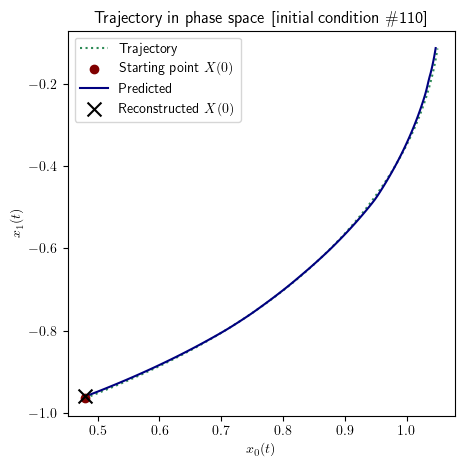

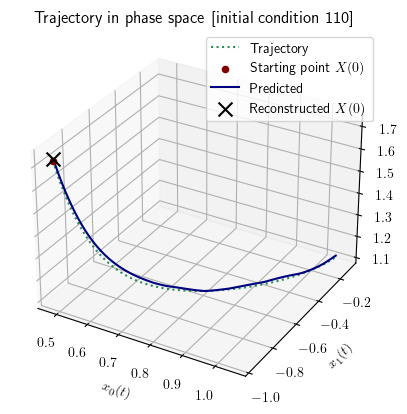

In [ ]:
RAN=np.random.randint(0,len(XT[0].cpu().detach().numpy()))
X_traj=XT.permute((1,2,0)).cpu().detach().numpy()[RAN]
Y_traj=YT.permute((1,2,0)).cpu().detach().numpy()[RAN]

fig,ax=plt.subplots(1,figsize=(5,5))
ax.set_title(f"Trajectory in phase space [initial condition \#{RAN}]")
ax.set_xlabel(r"$x_0(t)$")
ax.set_ylabel(r"$x_1(t)$")
ax.plot(X_traj[0],X_traj[1],label="Trajectory",linestyle='dotted',alpha=1,color='seagreen',zorder=0)
ax.scatter(X_traj[0][0],X_traj[1][0],marker='o',color='maroon',label='Starting point $X(0)$',alpha=1,zorder=1)

ax.plot(Y_traj[0],Y_traj[1],label="Predicted",color='navy',zorder=0)
ax.scatter(Y_traj[0][0],Y_traj[1][0],marker='x',s=100,color='black',label='Reconstructed $X(0)$',zorder=1)
ax.legend()
fig.savefig(f"{figDir}/{exp[option-1]}-random_trajectory-#{RAN}.png",dpi=600)

if len(X_traj)>2:
    fig3D = plt.figure()
    ax3D = plt.axes(projection='3d')
    
    ax3D.set_title(f"Trajectory in phase space [initial condition \#{RAN}]")
    ax3D.set_xlabel(r"$x_0(t)$")
    ax3D.set_ylabel(r"$x_1(t)$")
    ax3D.set_zlabel(r"$x_2(t)$")
    ax3D.plot3D (X_traj[0],X_traj[1],X_traj[2],label="Trajectory",linestyle='dotted',alpha=1,color='seagreen',zorder=0)
    ax3D.scatter(X_traj[0][0],X_traj[1][0],X_traj[2][0],marker='o',color='maroon',label='Starting point $X(0)$',alpha=1,zorder=1)

    ax3D.plot(Y_traj[0],Y_traj[1],Y_traj[2],label="Predicted",color='navy',zorder=0)
    ax3D.scatter(Y_traj[0][0],Y_traj[1][0],Y_traj[2][0],marker='x',s=100,color='black',label='Reconstructed $X(0)$',zorder=1)
    ax3D.legend()
    fig3D.savefig(f"{figDir}/{exp[option-1]}-3D_random_trajectory.png-#{RAN}",dpi=600)
    
    
